# Simulation code

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import statsmodels.api as sm

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [2]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

## Test statistics TR

In [3]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]


    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics LSTR

In [4]:
def cal_g_theta_LSTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     LSTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics ESTR


In [5]:
def cal_g_theta_ESTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     ESTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Simulation 1

In [6]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

In [7]:
def MonteCarlo_1(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_1(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_1(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the corresponding lost function of interest
        delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size,T_size)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)

    
def sim_model_1(T_size):

    # Initialize delta1, delta2 and v
    delta1 = delta2 = v = 1

    # Simulate the model
    z1 = np.random.normal(0,1,(T_size,1))
    z2 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size):
    
    # Compile z1 and z2
    sim_z1 = np.column_stack([np.ones((T_size,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T_size,1)),sim_z2])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z1_sel = sim_z1[t-R_size:t-1]
        z2_sel = sim_z2[t-R_size:t-1]
        y_sel = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        # Estimate the two forecasts
        forecast1 = beta_1[0] + sim_z1[t,1] * beta_1[1]
        forecast2 = beta_2[0] + sim_z2[t,1] * beta_2[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2
    
    # Return the vector of the loss function of interest
    return delta_L

In [42]:
#simulation speed:
MC_iterations = 1
grid_elements = 20
iterations_CV = 100
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = False

print("---TR model---")
model_type = "TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---LSTR model---")
model_type = "LSTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---ESTR model---")
model_type = "ESTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 1.0
For R = 50
And P = 50
The rejection rate is 0.0
For R = 50
And P = 100
The rejection rate is 0.0
For R = 50
And P = 200
The rejection rate is 0.0
For R = 50
And P = 1000
The rejection rate is 0.0
For R = 100
And P = 50


<ipython-input-41-ff0cc37de568>:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], _, _ = MonteCarlo_iteration_1(R,P,T)


The rejection rate is 0.0
For R = 100
And P = 100
The rejection rate is 0.0
For R = 100
And P = 200
The rejection rate is 0.0
For R = 100
And P = 1000
The rejection rate is 0.0
---LSTR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 0.0
For R = 50
And P = 50
The rejection rate is 0.0
For R = 50
And P = 100
The rejection rate is 0.0
For R = 50
And P = 200
The rejection rate is 0.0
For R = 50
And P = 1000
The rejection rate is 0.0
For R = 100
And P = 50
The rejection rate is 0.0
For R = 100
And P = 100
The rejection rate is 0.0
For R = 100
And P = 200
The rejection rate is 0.0
For R = 100
And P = 1000
The rejection rate is 0.0
---ESTR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 0.0
F

# Simulation 2

In [8]:
def MonteCarlo_2(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_2)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_2(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_2(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_2(delta_L_1,sim_S_t[R_size-1:T_size-1],c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_2(R_size, P_size, T_size)


def cal_delta_L_2(delta_L_old,S_sel,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
    
    # Return the loss function of interest
    return delta_L

In [135]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Values for P to loop over
P_MC_array = [50,100,200]

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.014
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.013
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 100
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.032
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

0.0
0.1
0.1
0.1
0.0
0.0
0.0
0.0
0.1


[0.  0.  0.1 0.5 0.5 0.9 1.  1.  1.  1.  1. ]
[0.1 0.  0.1 0.3 0.7 0.8 1.  0.9 1.  1.  1. ]
[0.  0.1 0.1 0.2 0.6 0.6 0.7 1.  1.  1.  1. ]


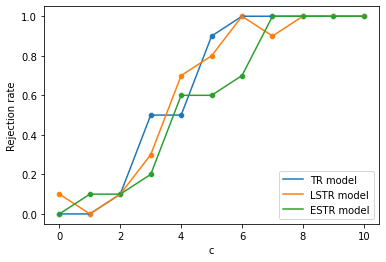

[0.  0.  0.5 1.  1.  1.  1.  1.  1.  1.  1. ]
[0.  0.5 0.6 1.  1.  1.  1.  1.  1.  1.  1. ]
[0.1 0.2 0.6 0.8 1.  1.  1.  1.  1.  1.  1. ]


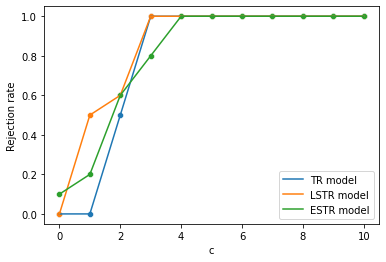

In [53]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
        
model_type = "LSTR"
signi_level = 0.014
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
        
model_type = "ESTR"
signi_level = 0.013
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
    
model_type = "ESTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Simulation 3

In [8]:
def MonteCarlo_3(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_3)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_3(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_3(T_size)
        
        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_3(R_size, P_size, T_size)

    
def sim_model_3(T_size):

    # Initialize delta and v
    delta = v = 1

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta * z_t + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z_t, y_t, S_t


def cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size, T_size):
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)
        
        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_REC)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)

        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)

        # Estimate the two forecasts
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_REC)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

In [54]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50
The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 25
And P = 100


<ipython-input-53-a7d70d5b1be4>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)


The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 25
And P = 200
The rejection rate is 0.2
The rate of delta_L being positive is 0.9
For R = 25
And P = 1000
The rejection rate is 1.0
The rate of delta_L being positive is 1.0
For R = 50
And P = 50
The rejection rate is 0.1
The rate of delta_L being positive is 0.5
For R = 50
And P = 100
The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 50
And P = 200
The rejection rate is 0.2
The rate of delta_L being positive is 0.8
For R = 50
And P = 1000
The rejection rate is 0.8
The rate of delta_L being positive is 1.0
For R = 100
And P = 50
The rejection rate is 0.2
The rate of delta_L being positive is 0.6
For R = 100
And P = 100
The rejection rate is 0.1
The rate of delta_L being positive is 0.6
For R = 100
And P = 200
The rejection rate is 0.0
The rate of delta_L being positive is 0.4
For R = 100
And P = 1000
The rejection rate is 0.3
The rate of delta_L being positive is 0.8
---ROLFIX model--

# Simulation 4

In [69]:
def MonteCarlo_4(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_4)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_4(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_4(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_4(T_size)

        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_4(R_size, P_size, T_size)

    
def sim_model_4(T_size):

    # Initialize and v
    v = 1
    
    steps = np.random.normal(0, 0.1, size=T_size)
    delta_t = (np.cumsum(steps) + 1).reshape(T_size,1)

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta_t * z_t + np.random.normal(0, 1, (T_size,1))
    # Return parameter vectors
    return z_t, y_t, S_t

In [71]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50
The rejection rate is 0.3
The rate of delta_L being positive is 0.4
For R = 25
And P = 100
The rejection rate is 0.3
The rate of delta_L being positive is 0.4
For R = 25
And P = 200
The rejection rate is 0.4
The rate of delta_L being positive is 0.2
For R = 25
And P = 1000
The rejection rate is 0.9
The rate of delta_L being positive is 0.1
For R = 50
And P = 50
The rejection rate is 0.2
The rate of delta_L being positive is 0.3
For R = 50
And P = 100
The rejection rate is 0.4
The rate of delta_L being positive is 0.1
For R = 50
And P = 200
The rejection rate is 0.4
The rate of delta_L being positive is 0.1
For R = 50
And P = 1000
The rejection rate is 1.0
The rate of delta_L being positive is 0.0
For R = 100
And P = 50
The rejection rate is 0.3
The rate of delta_L being positive is 0.2
For R = 100
And P = 100
The rejection rate is 0.7
The rate of delta_L being positive is 0.1
For R = 100
And P = 200
The rejection rate is 0.4
The rate of delta_L 

# Simulation 5

In [226]:
def MonteCarlo_5(R,P,T):
    
    if (parallelization == True):    
        
        # Define variable to keep track of amount of rejects
        loss_mean = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_5)(R,P,T) for i in range(MC_iterations))
                
    else:
        loss_mean = np.zeros(P)    
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            loss_mean += (MonteCarlo_iteration_5(R,P,T))

    # Return the rejection rate
    return loss_mean / MC_iterations

def MonteCarlo_iteration_5(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        # Simulate the model
        sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, sim_S_t = sim_model_5(T_size)

        delta_L = cal_delta_L_5(sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size)
        
        return np.transpose(np.absolute(delta_L))[0]
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_5(R_size, P_size, T_size)

    
def sim_model_5(T_size):

    # Initialize and v
    v = 1
    delta1 = 0.1
    delta2 = 0
    delta3 = 0.1
    delta4 = 0
    
    # Simulate the model
    z_1 = np.random.normal(0,1,(T_size,1))
    z_2 = np.random.normal(0,1,(T_size,1))
    z_3 = np.random.normal(0,1,(T_size,1))
    z_4 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z_1 + delta2 * z_2 + delta3 * z_3 + delta4 * z_4 + np.random.normal(0, 1, (T_size,1))
    
    # Return parameter vectors
    return z_1, z_2, z_3, z_4, y_t, S_t

def cal_delta_L_5(sim_z_1,sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size):
    
    # Compile z_t
    sim_z_t1 = np.column_stack([np.ones((T_size,1)),sim_z_1,sim_z_2])
    sim_z_t2 = np.column_stack([np.ones((T_size,1)),sim_z_3,sim_z_4])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
        
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel1 = sim_z_t1[0:t-1]
        z_sel2 = sim_z_t2[0:t-1]
        y_sel = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta1 = estimateBeta(z_sel1,y_sel)
        beta2 = estimateBeta(z_sel2,y_sel)
        
        # Estimate the two forecasts
        forecast1 = beta1[0] + sim_z_t1[t,1] * beta1[1] + sim_z_t1[t,2] * beta1[2]
        forecast2 = beta2[0] + sim_z_t2[t,1] * beta2[1] + sim_z_t2[t,2] * beta2[2]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2 
    # Return the vector of the loss function of interest
    return delta_L

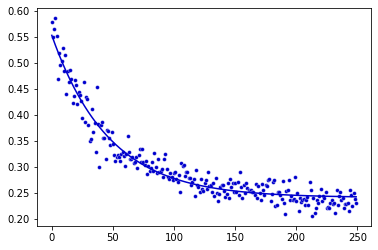

In [250]:
#simulation speed:
MC_iterations = 500

# Values for P to loop over
R_MC = 25
P_MC = 250

# Adjustable variables
parallelization = False

# for i in range(len(P_MC_array)):
T_MC = R_MC + P_MC
loss_array = MonteCarlo_5(R_MC,P_MC,T_MC)

sns.scatterplot(x=np.arange(P_MC), y=loss_array,color='mediumblue',s=15)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

import scipy.optimize 

params, cv = scipy.optimize.curve_fit(monoExp, np.arange(P_MC), loss_array, (2, .5, 50))
m, t, b = params
sns.lineplot(x=np.arange(P_MC), y=monoExp(np.arange(P_MC), m, t, b),color='mediumblue')

plt.show()

# New Models

In [9]:
def TV_TR_model(S_t, gamma,kappa,T_size):
    return ((S_t >= gamma).astype(float) / (np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))).reshape(-1, 1)

def TV_LSTR_model(S_t,gamma,tau,kappa,T_size):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

def TV_ESTR_model(S_t,gamma,tau,kappa,T_size):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

In [399]:
def cal_g_theta_TV_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and kappa values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements)
    
    # Get Q_t
    Q_t = np.stack([np.column_stack(((np.exp(-kappa_array[i]*np.arange(0,T_size)/T_size).reshape(T_size,1)),TV_TR_model(S_t,np.quantile(S_t,gamma_quantile[i]),kappa_array[i],T_size)))
                                                                     for i in range(grid_elements**2)])

    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]
    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)
    
    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0


# Simulation 6

In [11]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = False

print("---TV-TR model---")
model_type = "TV-TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TV-TR model---
For R = 25
And P = 50
The rejection rate is 0.1
For R = 25
And P = 100
The rejection rate is 0.2
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 0.1
For R = 50
And P = 50
The rejection rate is 0.1
For R = 50
And P = 100
The rejection rate is 0.0
For R = 50
And P = 200
The rejection rate is 0.2
For R = 50
And P = 1000
The rejection rate is 0.1
For R = 100
And P = 50
The rejection rate is 0.1
For R = 100
And P = 100
The rejection rate is 0.0
For R = 100
And P = 200
The rejection rate is 0.1
For R = 100
And P = 1000
The rejection rate is 0.0


# Simulation 7

In [426]:
def MonteCarlo_7(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_7)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_7(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_7(delta_L_1,sim_S_t[R_size-1:T_size-1],T_size,R_size,c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_7(R_size, P_size, T_size)


def cal_delta_L_7(delta_L_old,S_sel,T_size,R_size,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
   
    delta_L = delta_L / (np.exp(1 * np.arange(T_size)/T_size)[R_size-1:T_size-1]).reshape(-1,1)

    # Return the loss function of interest
    return delta_L

In [439]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 600
grid_elements = 7
iterations_CV = 1000
c_length = 11

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC

# model_type = "TR"
# signi_level = 0.035
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

# model_type = "TV-TR"
# signi_level = 0.008
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.036
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

model_type = "TV-TR"
signi_level = 0.034
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

0.05
0.06


<ipython-input-11-2e23cac9f248>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)


[0. 1.]
[[[-2.92312212e-01]
  [ 3.35270418e-01]]

 [[-2.70476873e-01]
  [ 3.24469748e-01]]

 [[-1.54677420e-01]
  [ 1.96124216e-01]]

 [[-2.62680364e-01]
  [ 3.71651356e-01]]

 [[-1.84762920e-01]
  [ 2.69955565e-01]]

 [[ 3.64889982e-02]
  [-9.62133344e-02]]

 [[-1.39391918e-02]
  [-6.63707156e-03]]

 [[-1.18518276e-02]
  [-1.10772829e-02]]

 [[ 4.99691235e-04]
  [-3.88916528e-02]]

 [[ 3.16793316e-03]
  [-4.67236414e-02]]

 [[ 4.04977785e-02]
  [-1.37829161e-01]]

 [[ 4.60070563e-02]
  [-1.58493813e-01]]

 [[ 1.19300723e-01]
  [-3.79697756e-01]]

 [[ 1.32270959e-01]
  [-4.98871426e-01]]

 [[ 1.52329630e-01]
  [-6.52769611e-01]]

 [[ 1.52329630e-01]
  [-6.52769611e-01]]

 [[ 1.29898778e-01]
  [-6.69496579e-01]]

 [[ 1.29898778e-01]
  [-6.69496579e-01]]

 [[ 1.29898778e-01]
  [-6.69496579e-01]]

 [[ 1.14703960e-01]
  [-7.33857941e-01]]

 [[-2.96430729e-01]
  [ 3.67936035e-01]]

 [[-2.73501312e-01]
  [ 3.54833085e-01]]

 [[-1.56979026e-01]
  [ 2.15535904e-01]]

 [[-2.62231493e-01]
  [ 4.

<ipython-input-11-2e23cac9f248>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)


[[[ 1.82600896e-01]
  [-3.05191425e-01]]

 [[ 4.47758295e-01]
  [-6.35387921e-01]]

 [[ 4.47758295e-01]
  [-6.35387921e-01]]

 [[-6.02383419e-02]
  [-3.21615201e-02]]

 [[-6.02259180e-02]
  [-3.30021026e-02]]

 [[-7.57955005e-02]
  [-1.41278576e-02]]

 [[-6.99652017e-02]
  [-2.28605089e-02]]

 [[-1.46319076e-01]
  [ 9.42992473e-02]]

 [[-2.59231676e-01]
  [ 2.98731238e-01]]

 [[-1.84282449e-01]
  [ 1.82064613e-01]]

 [[-2.11434327e-01]
  [ 2.50933538e-01]]

 [[-1.22685089e-01]
  [ 8.34489348e-02]]

 [[-1.08295791e-01]
  [ 5.87585085e-02]]

 [[-1.05960697e-01]
  [ 6.24785609e-02]]

 [[-7.49616865e-02]
  [-3.93066840e-02]]

 [[-7.57324121e-02]
  [-4.26464410e-02]]

 [[-3.28482924e-02]
  [-2.65596328e-01]]

 [[-8.14721153e-02]
  [-2.49746813e-02]]

 [[-7.56835905e-02]
  [-6.42747964e-02]]

 [[-7.56835905e-02]
  [-6.42747964e-02]]

 [[ 2.01496071e-01]
  [-3.53165949e-01]]

 [[ 4.57720893e-01]
  [-6.99625172e-01]]

 [[ 4.57720893e-01]
  [-6.99625172e-01]]

 [[-5.65633463e-02]
  [-3.97463773

[[[ 2.99572104e-01]
  [ 2.57482787e-01]]

 [[ 4.37424875e-01]
  [ 9.80409624e-02]]

 [[ 6.98831059e-01]
  [-2.54129742e-01]]

 [[ 6.83371693e-01]
  [-2.46344188e-01]]

 [[ 5.26810866e-01]
  [-1.76664860e-02]]

 [[ 5.04042972e-01]
  [ 1.96911223e-02]]

 [[ 5.71646817e-01]
  [-1.03313281e-01]]

 [[ 6.10648607e-01]
  [-1.89581925e-01]]

 [[ 6.36184449e-01]
  [-2.73470010e-01]]

 [[ 6.36184449e-01]
  [-2.73470010e-01]]

 [[ 5.71033079e-01]
  [-1.37938584e-01]]

 [[ 5.71033079e-01]
  [-1.37938584e-01]]

 [[ 6.20190388e-01]
  [-2.74559850e-01]]

 [[ 6.85110506e-01]
  [-4.70146836e-01]]

 [[ 6.57349222e-01]
  [-4.16151697e-01]]

 [[ 6.16077618e-01]
  [-3.34066577e-01]]

 [[ 6.35044635e-01]
  [-4.25667823e-01]]

 [[ 6.75717097e-01]
  [-6.14844045e-01]]

 [[ 6.51339884e-01]
  [-6.15828361e-01]]

 [[ 6.50238352e-01]
  [-7.46559486e-01]]

 [[ 3.09095011e-01]
  [ 2.66022913e-01]]

 [[ 4.46114871e-01]
  [ 9.41978894e-02]]

 [[ 7.03553301e-01]
  [-2.81623740e-01]]

 [[ 6.87021823e-01]
  [-2.71916251

[[[ 0.60914032]
  [-0.62075329]]

 [[ 0.51511726]
  [-0.52123135]]

 [[ 0.47172767]
  [-0.48002515]]

 [[ 0.29282761]
  [-0.26989481]]

 [[ 0.10603544]
  [-0.02695278]]

 [[ 0.09528039]
  [-0.01147399]]

 [[ 0.33182525]
  [-0.39373822]]

 [[ 0.33182525]
  [-0.39373822]]

 [[ 0.30300408]
  [-0.35882754]]

 [[ 0.2563663 ]
  [-0.30117634]]

 [[ 0.24275087]
  [-0.28711726]]

 [[ 0.24275087]
  [-0.28711726]]

 [[ 0.22720781]
  [-0.27900051]]

 [[ 0.17639231]
  [-0.20155627]]

 [[ 0.22987156]
  [-0.35541002]]

 [[ 0.21423533]
  [-0.35146606]]

 [[ 0.1597863 ]
  [-0.24026249]]

 [[ 0.13699314]
  [-0.20535662]]

 [[ 0.10811409]
  [-0.12754084]]

 [[ 0.10811409]
  [-0.12754084]]

 [[ 0.62414884]
  [-0.68891297]]

 [[ 0.52822436]
  [-0.57971724]]

 [[ 0.48372613]
  [-0.5344042 ]]

 [[ 0.30169998]
  [-0.30412503]]

 [[ 0.11172777]
  [-0.03813724]]

 [[ 0.10063738]
  [-0.0211515 ]]

 [[ 0.3337521 ]
  [-0.42859339]]

 [[ 0.3337521 ]
  [-0.42859339]]

 [[ 0.30472078]
  [-0.39080455]]

 [[ 0.25761115

[[[-1.64819249e-01]
  [ 5.78888605e-04]]

 [[-1.97449049e-01]
  [ 4.13950822e-02]]

 [[ 1.02343936e-01]
  [-3.50890682e-01]]

 [[ 1.29075351e-01]
  [-4.07511575e-01]]

 [[ 9.81699562e-02]
  [-3.97731726e-01]]

 [[ 1.35889470e-01]
  [-4.69097582e-01]]

 [[ 1.24155805e-01]
  [-4.65304496e-01]]

 [[ 7.36329403e-02]
  [-4.10286074e-01]]

 [[-1.33497679e-02]
  [-2.90352337e-01]]

 [[-2.44589405e-02]
  [-2.91404255e-01]]

 [[-4.63917679e-02]
  [-2.80812417e-01]]

 [[-1.13678703e-01]
  [-1.26635700e-01]]

 [[-1.02191534e-01]
  [-1.72615136e-01]]

 [[-1.01608284e-01]
  [-1.96014685e-01]]

 [[-1.01608284e-01]
  [-1.96014685e-01]]

 [[-1.25206750e-02]
  [-5.83893492e-01]]

 [[ 3.54760078e-02]
  [-9.08222685e-01]]

 [[ 3.67625136e-02]
  [-1.00547748e+00]]

 [[-3.72310561e-02]
  [-7.94387042e-01]]

 [[-8.16090754e-02]
  [-6.89365896e-01]]

 [[-1.63031214e-01]
  [-1.67288577e-03]]

 [[-1.95405070e-01]
  [ 4.19428867e-02]]

 [[ 9.81413108e-02]
  [-3.72592840e-01]]

 [[ 1.24749869e-01]
  [-4.32964490

[[[ 0.08397596]
  [-0.32620972]]

 [[-0.04690276]
  [-0.1891977 ]]

 [[-0.55612895]
  [ 0.43314521]]

 [[-0.53805637]
  [ 0.44384268]]

 [[-0.41254992]
  [ 0.29843697]]

 [[-0.33347928]
  [ 0.19978467]]

 [[-0.38165255]
  [ 0.28673294]]

 [[-0.38015753]
  [ 0.3158236 ]]

 [[-0.41478044]
  [ 0.42743261]]

 [[-0.3984723 ]
  [ 0.41056417]]

 [[-0.36870351]
  [ 0.37878745]]

 [[-0.3212181 ]
  [ 0.2790133 ]]

 [[-0.33530019]
  [ 0.34913169]]

 [[-0.3606298 ]
  [ 0.47192818]]

 [[-0.35226001]
  [ 0.47549075]]

 [[-0.32067307]
  [ 0.42715495]]

 [[-0.2591073 ]
  [ 0.22497505]]

 [[-0.19585055]
  [-0.08601395]]

 [[-0.18576815]
  [-0.17031883]]

 [[-0.17951023]
  [-0.30102556]]

 [[ 0.08761615]
  [-0.35648446]]

 [[-0.04454324]
  [-0.20723464]]

 [[-0.55959578]
  [ 0.47247996]]

 [[-0.53908842]
  [ 0.48029598]]

 [[-0.41487519]
  [ 0.32595318]]

 [[-0.33389127]
  [ 0.21661308]]

 [[-0.38212175]
  [ 0.31071797]]

 [[-0.38107781]
  [ 0.34327799]]

 [[-0.41579377]
  [ 0.46416625]]

 [[-0.39947326

[[[-2.80517187e-01]
  [ 4.65979836e-01]]

 [[-8.14023298e-02]
  [ 2.45887563e-01]]

 [[-9.84337750e-03]
  [ 1.71143223e-01]]

 [[-1.90213212e-03]
  [ 1.74468006e-01]]

 [[ 1.10466341e-01]
  [ 1.47865622e-02]]

 [[ 7.82597833e-02]
  [ 6.55713884e-02]]

 [[ 1.36518345e-01]
  [-2.71547883e-02]]

 [[ 6.02984833e-02]
  [ 1.03322394e-01]]

 [[ 6.31810146e-02]
  [ 1.09700879e-01]]

 [[ 1.06953890e-01]
  [ 2.88512650e-02]]

 [[ 1.49288765e-01]
  [-6.91983175e-02]]

 [[ 1.40032810e-01]
  [-5.21245738e-02]]

 [[ 1.40855291e-01]
  [-5.73050540e-02]]

 [[ 1.05757198e-01]
  [ 4.25537473e-02]]

 [[ 1.58693784e-01]
  [-1.28227706e-01]]

 [[ 1.51669110e-01]
  [-1.12298706e-01]]

 [[ 9.53004202e-02]
  [ 1.13295689e-01]]

 [[ 6.37047499e-02]
  [ 3.14004011e-01]]

 [[ 7.61009664e-02]
  [ 3.15175039e-01]]

 [[ 7.44445349e-02]
  [ 3.81507808e-01]]

 [[-2.93016936e-01]
  [ 5.19495892e-01]]

 [[-9.05721810e-02]
  [ 2.78005208e-01]]

 [[-1.32662757e-02]
  [ 1.89969672e-01]]

 [[-3.26919474e-03]
  [ 1.90776842

[[[ 1.01537973e-01]
  [-2.23401718e-01]]

 [[-2.43725189e-01]
  [ 1.81304451e-01]]

 [[-1.41187868e-01]
  [ 5.76654111e-02]]

 [[-2.45043266e-01]
  [ 1.97352271e-01]]

 [[-1.20736186e-01]
  [ 3.66866381e-02]]

 [[-1.02546283e-01]
  [ 1.17042868e-02]]

 [[-4.50345590e-02]
  [-8.33683011e-02]]

 [[-4.55894866e-02]
  [-8.83322376e-02]]

 [[-3.40479711e-03]
  [-1.83301485e-01]]

 [[-4.89281702e-02]
  [-1.00276890e-01]]

 [[-6.99970233e-02]
  [-5.96631342e-02]]

 [[-1.22296579e-01]
  [ 6.81025986e-02]]

 [[-1.75136815e-01]
  [ 2.22447987e-01]]

 [[-2.40492179e-01]
  [ 4.84788797e-01]]

 [[-2.29328202e-01]
  [ 4.79545224e-01]]

 [[-1.83396155e-01]
  [ 3.68085896e-01]]

 [[-1.83396155e-01]
  [ 3.68085896e-01]]

 [[-1.83396155e-01]
  [ 3.68085896e-01]]

 [[-1.87382948e-01]
  [ 4.19670039e-01]]

 [[-2.02202882e-01]
  [ 5.95263014e-01]]

 [[ 8.95167471e-02]
  [-2.26712776e-01]]

 [[-2.47141960e-01]
  [ 2.00223057e-01]]

 [[-1.42930791e-01]
  [ 6.46308114e-02]]

 [[-2.47534214e-01]
  [ 2.16590887

[[[ 6.50641773e-02]
  [-1.49328817e-01]]

 [[ 6.50641773e-02]
  [-1.49328817e-01]]

 [[ 1.87552616e-01]
  [-3.09905806e-01]]

 [[ 2.77633556e-01]
  [-4.44744190e-01]]

 [[ 2.90633478e-01]
  [-4.87507648e-01]]

 [[ 2.90633478e-01]
  [-4.87507648e-01]]

 [[ 2.68521567e-01]
  [-4.83667052e-01]]

 [[ 2.68521567e-01]
  [-4.83667052e-01]]

 [[ 2.87036738e-01]
  [-5.42826197e-01]]

 [[ 1.49870808e-01]
  [-3.62487649e-01]]

 [[ 1.82432403e-01]
  [-4.66931600e-01]]

 [[ 1.02765252e-01]
  [-3.39869335e-01]]

 [[ 3.01031840e-02]
  [-2.15417173e-01]]

 [[ 1.71154978e-02]
  [-2.15243129e-01]]

 [[ 1.57702287e-02]
  [-2.23947816e-01]]

 [[-6.01469910e-02]
  [-7.50125426e-04]]

 [[-6.59974155e-02]
  [ 2.55699402e-02]]

 [[-6.60620087e-02]
  [ 2.84499000e-02]]

 [[-7.14807143e-02]
  [ 6.94292851e-02]]

 [[-8.47564328e-02]
  [ 2.03203368e-01]]

 [[ 7.23852034e-02]
  [-1.70638709e-01]]

 [[ 7.23852034e-02]
  [-1.70638709e-01]]

 [[ 1.91765081e-01]
  [-3.40377049e-01]]

 [[ 2.82373840e-01]
  [-4.87064940

[[[ 1.60674617e-01]
  [-2.62061676e-01]]

 [[ 1.60001861e-01]
  [-2.73468317e-01]]

 [[ 2.08805629e-01]
  [-3.38079190e-01]]

 [[ 2.08805629e-01]
  [-3.38079190e-01]]

 [[ 2.89907056e-01]
  [-4.45229205e-01]]

 [[ 4.30750660e-01]
  [-6.65699410e-01]]

 [[ 3.67916877e-01]
  [-5.98780768e-01]]

 [[ 3.59592215e-01]
  [-6.21104438e-01]]

 [[ 2.08254386e-01]
  [-4.16816585e-01]]

 [[ 5.72201656e-02]
  [-2.13550092e-01]]

 [[ 4.48753025e-02]
  [-2.00093656e-01]]

 [[-6.86528846e-02]
  [-1.20889014e-02]]

 [[ 2.01038673e-02]
  [-2.07140780e-01]]

 [[-2.44492750e-03]
  [-1.73180866e-01]]

 [[-3.34861999e-02]
  [-1.09722872e-01]]

 [[-1.17588599e-02]
  [-1.86535387e-01]]

 [[-1.98031931e-02]
  [-1.73055307e-01]]

 [[-3.07229800e-02]
  [-1.58778255e-01]]

 [[-2.12980324e-02]
  [-2.07241765e-01]]

 [[-8.86327610e-02]
  [ 6.72593482e-02]]

 [[ 1.71161947e-01]
  [-2.96123356e-01]]

 [[ 1.65737869e-01]
  [-3.02783544e-01]]

 [[ 2.13379345e-01]
  [-3.71254917e-01]]

 [[ 2.13379345e-01]
  [-3.71254917

[[[-3.42579740e-01]
  [ 2.28048261e-01]]

 [[-3.64995590e-01]
  [ 2.60946816e-01]]

 [[-4.31575419e-01]
  [ 3.59687459e-01]]

 [[-3.74838576e-01]
  [ 3.02458614e-01]]

 [[-9.52684684e-02]
  [-8.44708072e-02]]

 [[-1.61083198e-01]
  [ 1.62322522e-02]]

 [[-1.16224858e-01]
  [-5.99902463e-02]]

 [[-1.15322369e-01]
  [-7.13936638e-02]]

 [[-9.79287526e-02]
  [-1.15414019e-01]]

 [[-9.93504661e-02]
  [-1.17428943e-01]]

 [[-9.93504661e-02]
  [-1.17428943e-01]]

 [[-2.00709024e-01]
  [ 1.18309101e-01]]

 [[-2.30112826e-01]
  [ 2.08141117e-01]]

 [[-1.87783579e-01]
  [ 1.08130525e-01]]

 [[-1.87783579e-01]
  [ 1.08130525e-01]]

 [[-1.68860713e-01]
  [ 6.37196866e-02]]

 [[-2.19070545e-01]
  [ 3.40256720e-01]]

 [[-2.19070545e-01]
  [ 3.40256720e-01]]

 [[-2.27090129e-01]
  [ 4.22616268e-01]]

 [[-1.98985582e-01]
  [ 2.99789880e-01]]

 [[-3.37001882e-01]
  [ 2.38808744e-01]]

 [[-3.61155207e-01]
  [ 2.76560668e-01]]

 [[-4.29038845e-01]
  [ 3.84958644e-01]]

 [[-3.72706409e-01]
  [ 3.23729959

[[[ 3.03682351e-01]
  [ 7.92767029e-02]]

 [[ 5.52256644e-01]
  [-2.33310081e-01]]

 [[ 5.52256644e-01]
  [-2.33310081e-01]]

 [[ 5.59583714e-01]
  [-2.49090702e-01]]

 [[ 6.46685097e-01]
  [-3.83903217e-01]]

 [[ 4.99873422e-01]
  [-1.96361577e-01]]

 [[ 4.44161007e-01]
  [-1.19171333e-01]]

 [[ 5.07867215e-01]
  [-2.45700775e-01]]

 [[ 4.82842721e-01]
  [-2.25135879e-01]]

 [[ 5.18790009e-01]
  [-3.09406725e-01]]

 [[ 6.07302862e-01]
  [-5.15278436e-01]]

 [[ 5.85055235e-01]
  [-5.11382032e-01]]

 [[ 5.52130601e-01]
  [-4.78567948e-01]]

 [[ 5.52130601e-01]
  [-4.78567948e-01]]

 [[ 5.45704704e-01]
  [-5.48218508e-01]]

 [[ 4.93613867e-01]
  [-4.74381100e-01]]

 [[ 5.05776459e-01]
  [-6.15916718e-01]]

 [[ 4.89118927e-01]
  [-6.60245257e-01]]

 [[ 4.67029297e-01]
  [-6.91103685e-01]]

 [[ 4.54971576e-01]
  [-7.05806628e-01]]

 [[ 3.08272716e-01]
  [ 7.97960395e-02]]

 [[ 5.62131714e-01]
  [-2.65866355e-01]]

 [[ 5.62131714e-01]
  [-2.65866355e-01]]

 [[ 5.68563691e-01]
  [-2.81994087

[[[ 5.72565410e-01]
  [-6.72261372e-01]]

 [[ 5.07564943e-01]
  [-6.06164910e-01]]

 [[ 3.48461999e-01]
  [-4.35702341e-01]]

 [[ 2.66819332e-01]
  [-3.41269146e-01]]

 [[ 2.82375991e-01]
  [-3.75181331e-01]]

 [[ 2.82375991e-01]
  [-3.75181331e-01]]

 [[ 1.35897488e-01]
  [-1.63130927e-01]]

 [[ 1.36614326e-01]
  [-1.75617265e-01]]

 [[ 1.22674887e-01]
  [-1.62812174e-01]]

 [[ 9.00396693e-02]
  [-1.06314147e-01]]

 [[ 9.36020073e-02]
  [-1.33740214e-01]]

 [[ 8.10432454e-02]
  [-1.10206982e-01]]

 [[ 4.53487116e-02]
  [-2.78747333e-02]]

 [[ 1.32597866e-02]
  [ 6.71766448e-02]]

 [[ 2.93753508e-02]
  [ 1.79365404e-02]]

 [[ 3.30063834e-02]
  [ 6.73049826e-03]]

 [[ 4.42770683e-02]
  [-4.76037767e-02]]

 [[ 3.54465593e-02]
  [-3.83470199e-03]]

 [[ 4.91150706e-02]
  [-1.19656314e-01]]

 [[ 3.58559745e-02]
  [-1.37457691e-02]]

 [[ 5.72462641e-01]
  [-7.27668835e-01]]

 [[ 5.07635907e-01]
  [-6.55988181e-01]]

 [[ 3.48693484e-01]
  [-4.72081491e-01]]

 [[ 2.67543949e-01]
  [-3.70213093

[[[ 0.75608838]
  [-0.79523853]]

 [[ 0.68782488]
  [-0.72811195]]

 [[ 0.61476805]
  [-0.70695785]]

 [[ 0.53483795]
  [-0.61020646]]

 [[ 0.5305335 ]
  [-0.66231605]]

 [[ 0.40643385]
  [-0.49402809]]

 [[ 0.40643385]
  [-0.49402809]]

 [[ 0.36136679]
  [-0.44716526]]

 [[ 0.32239077]
  [-0.42186086]]

 [[ 0.36777583]
  [-0.53886582]]

 [[ 0.31742042]
  [-0.47029253]]

 [[ 0.31742042]
  [-0.47029253]]

 [[ 0.3097543 ]
  [-0.49962302]]

 [[ 0.3097543 ]
  [-0.49962302]]

 [[ 0.18219815]
  [-0.18323704]]

 [[ 0.14101485]
  [-0.07541891]]

 [[ 0.07408294]
  [ 0.19089422]]

 [[ 0.06528667]
  [ 0.24823131]]

 [[ 0.06528667]
  [ 0.24823131]]

 [[ 0.06459432]
  [ 0.27651616]]

 [[ 0.75326397]
  [-0.85522644]]

 [[ 0.68525557]
  [-0.7824964 ]]

 [[ 0.61405203]
  [-0.76267157]]

 [[ 0.53373447]
  [-0.65775106]]

 [[ 0.52875466]
  [-0.7122063 ]]

 [[ 0.40548197]
  [-0.53138228]]

 [[ 0.40548197]
  [-0.53138228]]

 [[ 0.36053169]
  [-0.48009296]]

 [[ 0.32103033]
  [-0.45191179]]

 [[ 0.36730891

[[[-6.38279246e-02]
  [ 8.91662124e-02]]

 [[ 1.09703818e-01]
  [-1.26451441e-01]]

 [[ 1.76645302e-01]
  [-2.23748119e-01]]

 [[ 1.76645302e-01]
  [-2.23748119e-01]]

 [[ 1.76645302e-01]
  [-2.23748119e-01]]

 [[ 2.52241767e-01]
  [-3.44528676e-01]]

 [[ 3.01239285e-02]
  [-2.97691168e-02]]

 [[ 2.59401702e-02]
  [-2.56353042e-02]]

 [[ 2.61091172e-02]
  [-2.78470804e-02]]

 [[ 5.61255068e-02]
  [-8.66419480e-02]]

 [[ 2.79690104e-02]
  [-3.37946333e-02]]

 [[ 2.31003407e-02]
  [-2.61492325e-02]]

 [[ 8.59759570e-02]
  [-1.87260658e-01]]

 [[ 5.17998005e-02]
  [-1.07179228e-01]]

 [[ 5.17998005e-02]
  [-1.07179228e-01]]

 [[-6.74061596e-02]
  [ 2.45243292e-01]]

 [[-3.62585089e-02]
  [ 1.82039241e-01]]

 [[-3.62585089e-02]
  [ 1.82039241e-01]]

 [[-3.62585089e-02]
  [ 1.82039241e-01]]

 [[-4.39880259e-02]
  [ 2.75298598e-01]]

 [[-7.24462431e-02]
  [ 1.07354647e-01]]

 [[ 1.02270244e-01]
  [-1.26145910e-01]]

 [[ 1.69840440e-01]
  [-2.31455382e-01]]

 [[ 1.69840440e-01]
  [-2.31455382

KeyboardInterrupt: 

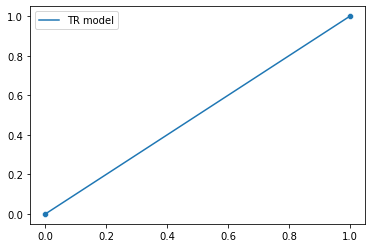

In [16]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 50
grid_elements = 20
iterations_CV = 1000
c_length = 2

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = False
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.035
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')

model_type = "TV-TR"
signi_level = 0.008
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.036
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.034
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()